In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import cv2
import scipy

# third party packages
from PIL import Image

# from my code
from repo_tools import shorten_image_file_names
from image_tools import convolve_image_horizontal_filter, find_all_non_white_pixels, identify_rgb_of_data, find_all_data_point_pixel_locations
from signals_processing_tools import remove_double_peaks, remove_baseline_wander, find_peaks, compute_y_calibrations
from data_tools import calculate_pixel_location, generate_dict_y_coords_for_kW

### find images

In [2]:
# old_img_names = os.listdir(os.path.join("data", "images"))
cwd = os.getcwd()
# old_img_paths = {img_name: os.path.join(cwd, "data", "images", img_name) for img_name in old_img_names}
# shorten_image_file_names(old_img_paths, cwd)

img_names = [img_name for img_name in os.listdir(os.path.join("data", "images")) if "png" in img_name]
img_paths = {img_name: os.path.join(cwd, "data", "images", img_name) for img_name in img_names}
img_paths.keys()

dict_keys(['123946.png', '124245.png', '124105.png', '124205.png'])

### import image

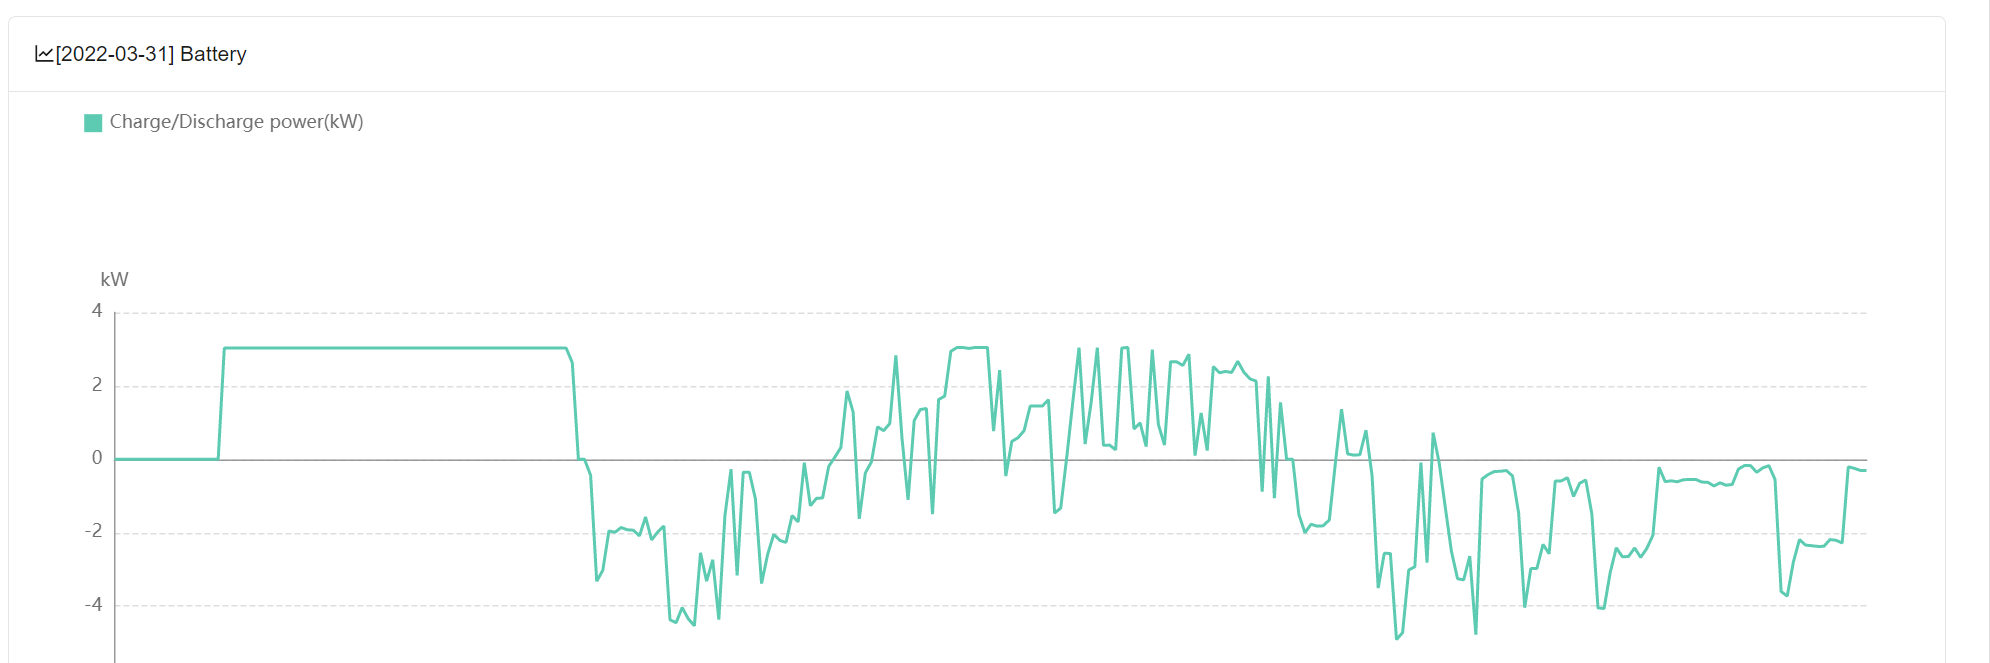

In [3]:
# exract the image
img = Image.open(img_paths[img_names[0]]).convert("RGB")

# show the image
img

This plot shows the charge and discharge data for Ian's home battery over a given day. The y axis represents the power consupmtion of the battery from the grid. Positive values, i.e. above the baseline, correspond to the battery being charged from the grid. Inversely, negative values represent when the battery is discharging, and helping to power the home. Currently this is being done in the simplest way possible, in that the battery charges up at night when the electricity prices are lower, and then it discharges in the day- to supply the houses electricity- when the cost of electricity is higher, therefore tapping into these 'delta' values in the price range of electricity to save money. This image shows the ideal scenario, in that the battery has not ran out of charge throughout the day and therefore the demand from the grid during the day was 0. Great.

However, this won't always happen, especially in winter when the household electricity demands are higher. The battery will run out at some point in the day. With this constraint in mind, we move to the real point of this project.

This process could be optimised to reduce the carbon footprint of the household. 

## Carbon intensity of the grid

The national grid has a continously changing proportion of its power coming supply coming from renewable sources. It would be ideal to charge up Ian's battery when the renewable proportion is highest, therefore the carbon intensity per kW is lowest. 

Furthermore, if the battery is programmed to discharge when the carbon intensity of the grid is at its highest, say in the early evening when everyone is at home and the grid has turned up the gas consumption to match demand, the battery discharge will serve the household electricity demands reducing the use of eletricity from the grid- within constraints as the battery has a maximum discharge rate.

If only we could predict the carbon intensity of the grid for the upcoming 24 hour period, in order to charge at the lowest, and discharge at the highest, carbon intensity values. 

Thanks to these guys, we do:

https://carbonintensity.org.uk

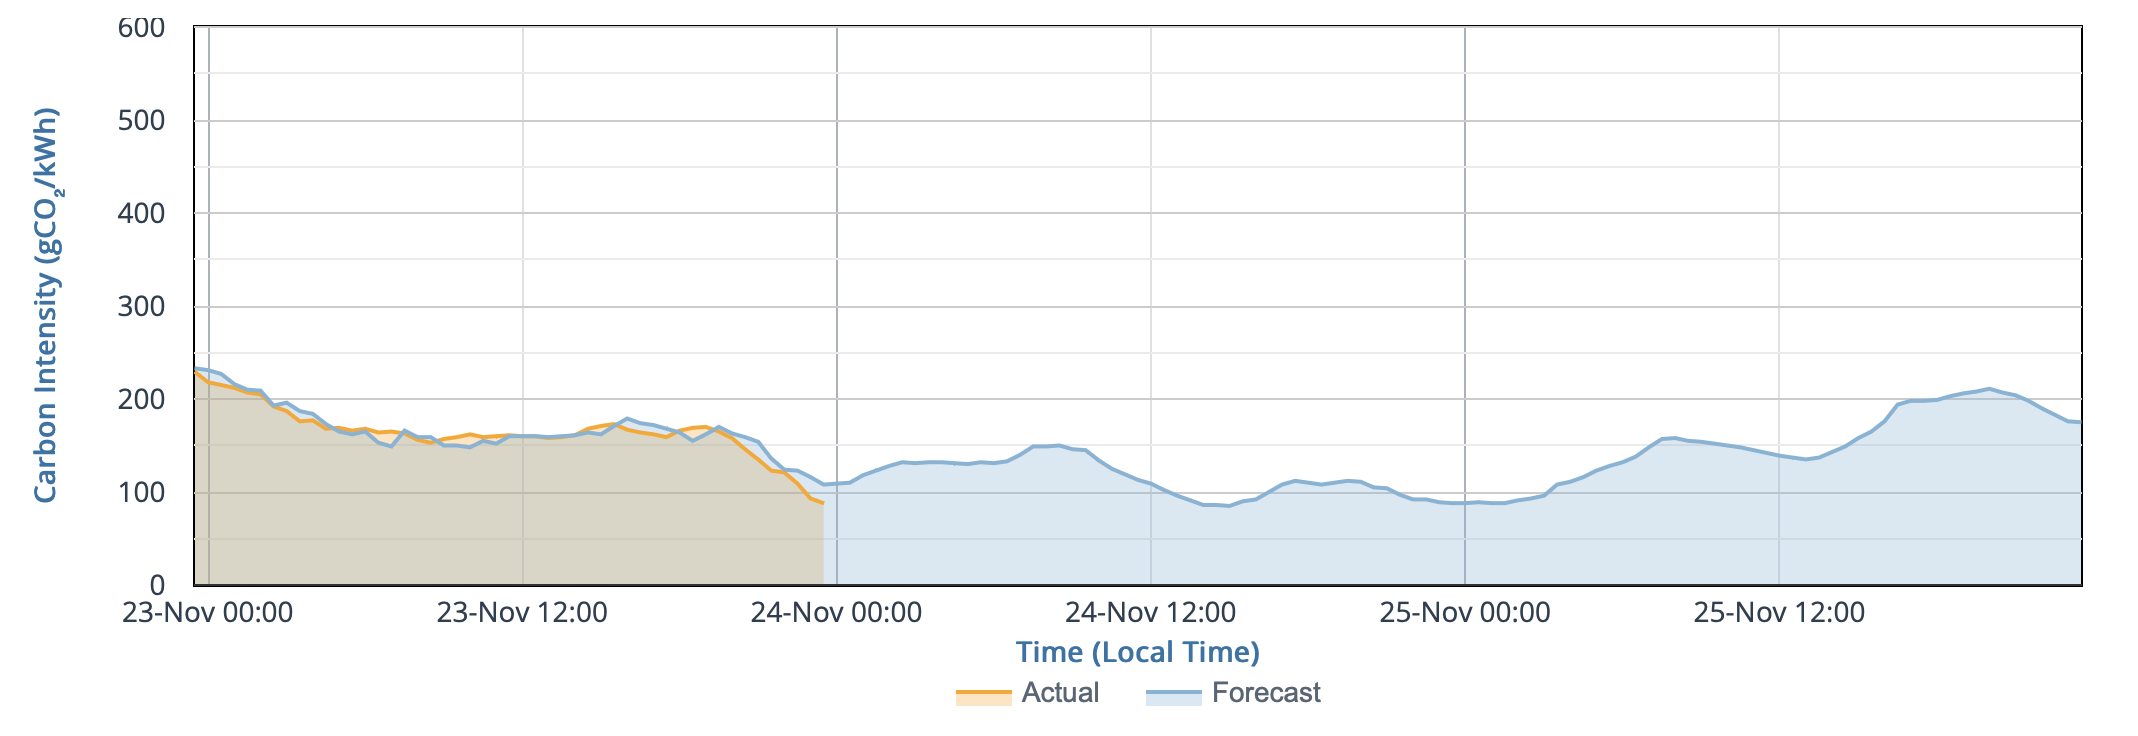

## Lets do some calculations

So, if we can predict the upcoming national grid carbon intensity within reason, lets see how much carbon could be saved if we adopted an 'intelligent' charge and discharge procedure. 

The starting point of this is to calculate the relative value of carbon intensity from the 'dumb' approach. And the data provided was these images provided. 

So, lets scrape the data from these images. Woopeeee

### Find the RGB values corresponding to data points in the plot

In [4]:
col_names = ['r', 'g', 'b']
df_coloured_pixels = find_all_non_white_pixels(img, col_names)

The following code uses a function found in the image_tools.py file. It takes all the RGB values of all the pixels in the images, ignoring white pixels, and finds the most common RGB value. This was found to correspond to the colour of the data. 

In [5]:
# target_col_dict = identify_rgb_of_data(df_coloured_pixels, col_names, show_plots=False)
target_col_dict, plots = identify_rgb_of_data(df_coloured_pixels, col_names, show_plots=True)
plots

Now that we know the pixel colour values corresponding to the data in the plot, a function to find all these datapoints from the image is needed using the target_col_dict.

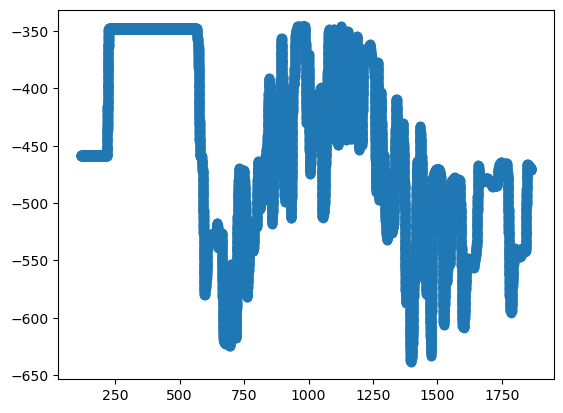

In [6]:
arr_data_pix_coords = find_all_data_point_pixel_locations(img, target_col_dict)

plt.scatter(arr_data_pix_coords[:,0], -1*arr_data_pix_coords[:,1])

Clearly this method has found the correct data points.

## y calibration

In [7]:
y_coord_dict, baseline_y, kw_per_pixel = compute_y_calibrations(img)

An outline of this method and how it was developed can be found in the image_processing_experiments.ipynb notebook. Code is found in various .py files. 

It uses Image processing methods such as 2d convolutions with a horizontal filter to detect horizontal lines through peak detection of the response to this convolutional filter.

#### checking y calibration

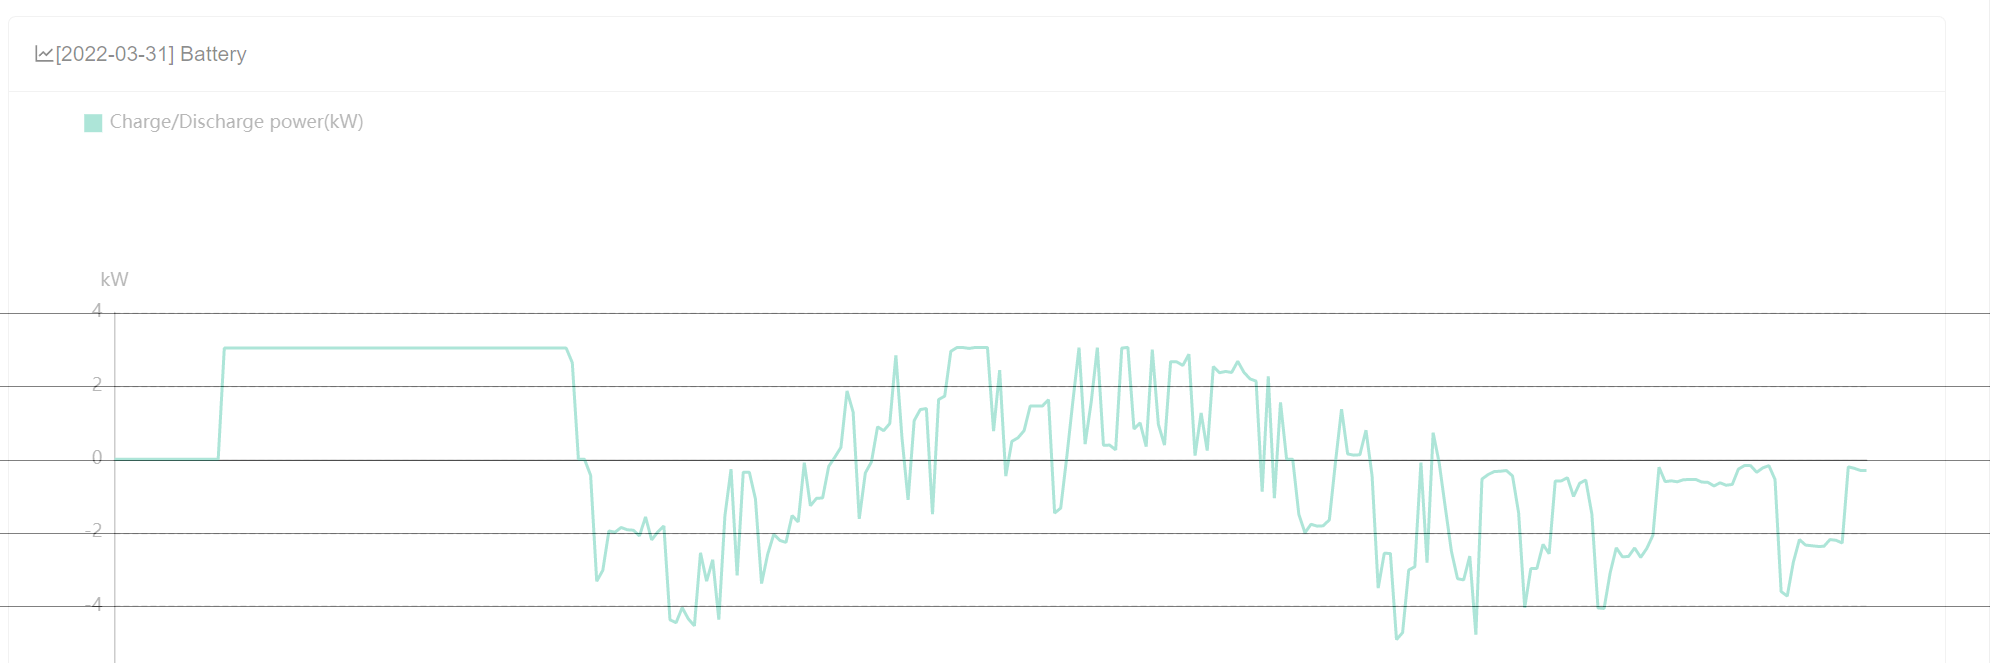

In [23]:
# check these values 
img_arr = np.asarray(img)
img_height = img_arr.shape[0]
img_width = img_arr.shape[1]
min(arr_data_pix_coords[:,1])

# generate white page with black lines image for pasting on top of original image, for reference
black_line_pix_values = np.zeros((1,img_width,3), dtype="uint8")
white_image = np.ones(np.shape(img_arr),dtype="uint8")*255
for y_val in y_coord_dict:
    white_image[y_coord_dict[y_val]] =  black_line_pix_values
    
lines = Image.fromarray(white_image)
img_with_lines = img.copy()
lines.putalpha(127) # make partially transparent

# paste the two images together
img_with_lines.paste(lines, (0,0), lines)
img_with_lines

This plot shows the original image with an overlay of the predicted y grid lines using the image processing tools defined in this repository. They should line up. 

## x calibration 

In [24]:
baseline_x = min(arr_data_pix_coords[:,0])
last_data_point_x = max(arr_data_pix_coords[:,0])
seconds_in_day = 60*60*24
seconds_per_pixel = seconds_in_day / abs(last_data_point_x - baseline_x)
baseline_x, seconds_per_pixel

(115, 49.371428571428574)

# putting them together

Text(0, 0.5, 'kW')

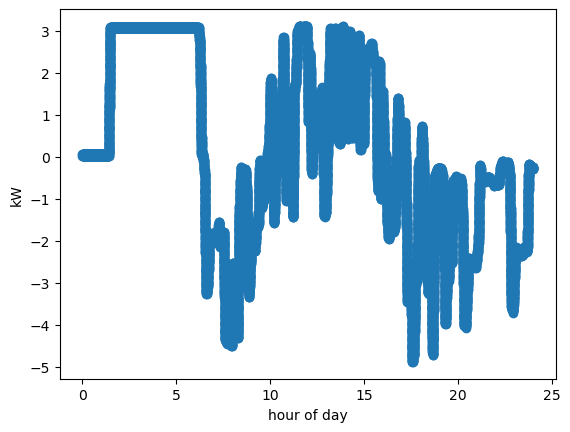

In [25]:
# extract array of data values with dimensions in Y of kW, and x of seconds in the day
data_x = (arr_data_pix_coords[:,0] - baseline_x) * seconds_per_pixel # x dimensions are seconds
data_y = (arr_data_pix_coords[:,1] - baseline_y) * kw_per_pixel # y direction are kW

plt.scatter(data_x*24/seconds_in_day, data_y)
plt.xlabel("hour of day")
plt.ylabel("kW")

This looks good.

In [26]:
# quick sanity check this number should be around 0
np.sum(data_y)/seconds_in_day

-0.06383169005182654

Close enough

# What to do with this data

Now we've scraped the data from these images, lets calculate the a carbon intensity metric.

For this, we need historic data on carbon intensity in the grid. 